**Import Required Libraries**

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, classification_report, precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)



**Load Datasets from GitHub**

In [6]:
data_url = "https://raw.githubusercontent.com/tanya-pal/Machine-Learning-Assignment-Stock-Price-Prediction-/main/Data.csv"
price_url = "https://raw.githubusercontent.com/tanya-pal/Machine-Learning-Assignment-Stock-Price-Prediction-/main/StockPrice.csv"

In [7]:
data_df = pd.read_csv(data_url)
price_df = pd.read_csv(price_url)
print(data_df.head())
print(price_df.head())

         Date   Data
0  2025-03-26  2.369
1  2025-03-25  2.365
2  2025-03-24  2.367
3  2025-03-21  2.386
4  2025-03-20  2.387
         Date    Price
0  2025-03-26  5759.50
1  2025-03-25  5826.50
2  2025-03-24  5815.50
3  2025-03-21  5718.25
4  2025-03-20  5712.75


**Merge and Sort by Date**

In [8]:
data_df['Date'] = pd.to_datetime(data_df['Date'])
price_df['Date'] = pd.to_datetime(price_df['Date'])

In [9]:
df = pd.merge(data_df, price_df, on='Date', how='inner')
df.head()
df = df.sort_values('Date').reset_index(drop=True)

**Feature Engineering**

In [10]:
# Change in Data
df['Data_Change'] = df['Data'].pct_change()

# Rolling features
df['Data_Change_MA3'] = df['Data_Change'].rolling(3).mean()
df['Data_Change_MA5'] = df['Data_Change'].rolling(5).mean()
df['Data_Change_STD3'] = df['Data_Change'].rolling(3).std()

# Price change
df['Price_Change'] = df['Price'].diff()

# Target is next day price change
df['NextDayPriceChange'] = df['Price_Change'].shift(-1)

df = df.dropna().reset_index(drop=True)
# Defining NextDayDirection for classification
df['NextDayDirection'] = (df['NextDayPriceChange'] > 0).astype(int)

**Define Features and Target**

In [11]:
# Defining X and y for classification
X = df[
    [
        'Data_Change',
        'Data_Change_MA3',
        'Data_Change_MA5',
        'Data_Change_STD3'
    ]
]

In [12]:
y = df['NextDayDirection'] # target is NextDayDirection for classification

**Time-Based Train-Test Split**

In [13]:
split_index = int(len(df) * 0.8)

In [14]:
X_train = X.iloc[:split_index]
X_test  = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test  = y.iloc[split_index:]


**Feature Scaling**

In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Train Regression Model**

In [16]:
# Use RandomForestClassifier for classification task
classifier = RandomForestClassifier(
    n_estimators=300,
    max_depth=5,
    random_state=42
)

classifier.fit(X_train_scaled, y_train)
y_pred = classifier.predict(X_test_scaled)


**Model Evaluation Metrics**

In [17]:

# Predictions already computed as y_pred

# Core metrics
accuracy  = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall    = recall_score(y_test, y_pred)
f1        = f1_score(y_test, y_pred)

print("Model Evaluation Metrics")

print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1 Score  : {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix")
print(cm)

# Full classification report
print("\nClassification Report")
print(classification_report(y_test, y_pred, target_names=["Down", "Up"]))


Model Evaluation Metrics
Accuracy  : 0.5303
Precision : 0.5304
Recall    : 0.9173
F1 Score  : 0.6722

Confusion Matrix
[[ 37 324]
 [ 33 366]]

Classification Report
              precision    recall  f1-score   support

        Down       0.53      0.10      0.17       361
          Up       0.53      0.92      0.67       399

    accuracy                           0.53       760
   macro avg       0.53      0.51      0.42       760
weighted avg       0.53      0.53      0.43       760



**Reconstruct Next-Day Stock Prices And Plot Actual vs Predicted Price**

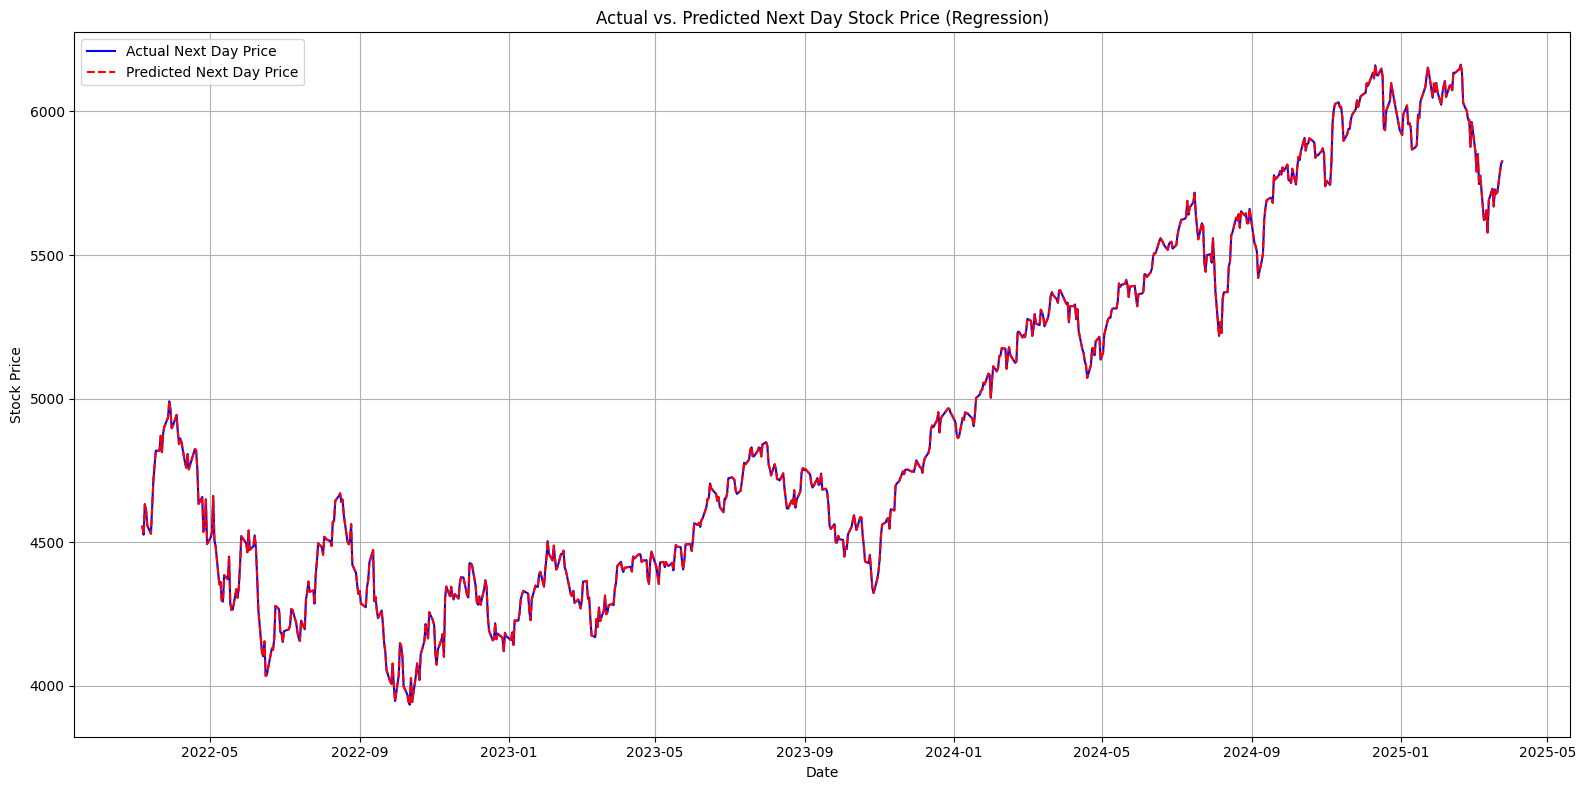

In [18]:

results_df = pd.DataFrame({
    'ActualNextDayPriceChange': y_test,
    'PredictedNextDayPriceChange': y_pred
})

# These are the prices on the day for which we predict the *change* for the *next* day
df_test_period = df.iloc[split_index:]
results_df['CurrentPrice'] = df_test_period['Price'].values
results_df['Date'] = df_test_period['Date'].values

# Calculating actual next day price and predicted next day price
results_df['ActualNextDayPrice'] = results_df['CurrentPrice'] + results_df['ActualNextDayPriceChange']
results_df['PredictedNextDayPrice'] = results_df['CurrentPrice'] + results_df['PredictedNextDayPriceChange']

plt.figure(figsize=(16, 8))
plt.plot(results_df['Date'], results_df['ActualNextDayPrice'], label='Actual Next Day Price', color='blue')
plt.plot(results_df['Date'], results_df['PredictedNextDayPrice'], label='Predicted Next Day Price', color='red', linestyle='--')

plt.title('Actual vs. Predicted Next Day Stock Price (Regression)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Visualization of Actual vs Predicted Price Direction**

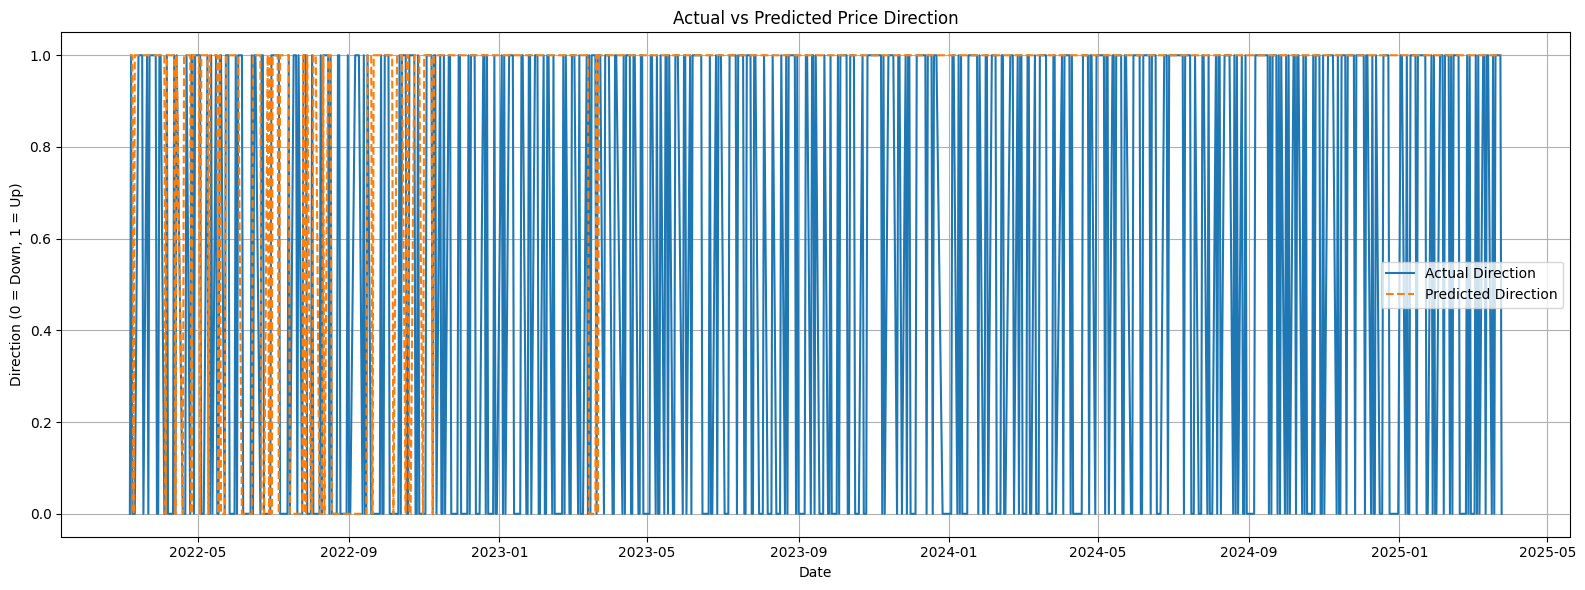

In [19]:
plt.figure(figsize=(16, 6))
plt.plot(results_df['Date'], results_df['ActualNextDayPriceChange'], label='Actual Direction')
plt.plot(results_df['Date'], results_df['PredictedNextDayPriceChange'], label='Predicted Direction', linestyle='--')

plt.title('Actual vs Predicted Price Direction')
plt.xlabel('Date')
plt.ylabel('Direction (0 = Down, 1 = Up)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Confusion Matrix**

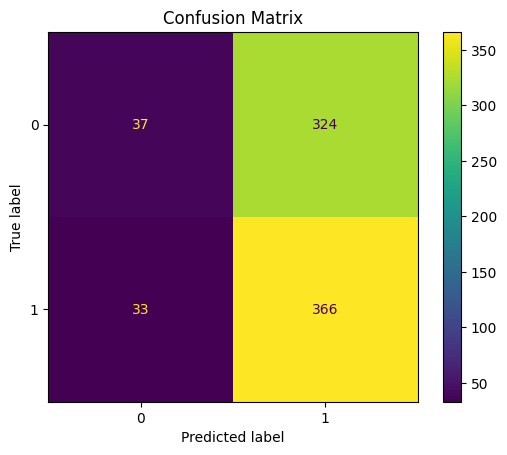

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(
    classifier,
    X_test_scaled,
    y_test
)

plt.title('Confusion Matrix')
plt.show()
